In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)

In [2]:
# import data
df_species = pd.read_parquet('../processed_data/species_coverage.parquet')

df_genes   = pd.read_parquet('../processed_data/gene_coverage.parquet')
df_genes = df_genes.set_index("Sample")

# match indexes
df_species = df_species.reindex(df_genes.index)

# Data Processing

In [3]:
count_species = (df_species > 0).sum(0)
count_genes = (df_genes > 0).sum(0)

# remove columns that rarely show up
threshold = 100

species_keep = count_species[count_species >= threshold].index
genes_keep = count_genes[count_genes >= threshold].index

df_species = df_species[species_keep]
df_genes = df_genes[genes_keep]

del species_keep
del genes_keep

# Logistic Regression

In [4]:
# convert genes to binary for logistic regression
df_genes_binary = (df_genes > 0).astype(int)

del df_genes

In [5]:
# for future reference
species_names = df_species.columns.tolist()
gene_names = df_genes_binary.columns.tolist()

#  -- tensors --
X = torch.tensor(df_species.values, dtype=torch.float32)  # Species as input
y = torch.tensor(df_genes_binary.values, dtype=torch.float32)  # Genes as output

# train val test split
total_samples = X.shape[0]
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size  # Ensures all samples are used

indices = torch.randperm(total_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

X_train, y_train = X[train_indices], y[train_indices]
X_val, y_val = X[val_indices], y[val_indices]
X_test, y_test = X[test_indices], y[test_indices]

# -- datasets and loaders --
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [7]:
input_size = X.shape[1]  # Number of species
output_size = y.shape[1]  # Number of genes
model = LogisticRegressionModel(input_size, output_size)

# loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# train loop
epochs = 5
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # average training loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # val
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    # average val loss
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch [1/5], Train Loss: 5.6883, Val Loss: 4.0221
Epoch [2/5], Train Loss: 4.1619, Val Loss: 3.9909
Epoch [3/5], Train Loss: 4.0021, Val Loss: 4.1588
Epoch [4/5], Train Loss: 3.9391, Val Loss: 4.1296
Epoch [5/5], Train Loss: 4.0019, Val Loss: 4.1117


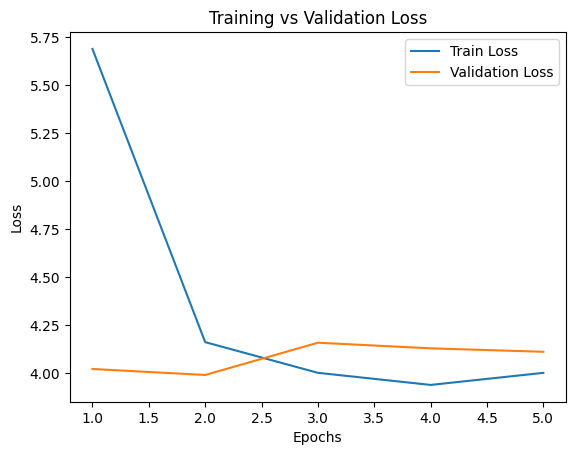

In [10]:
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()